# Relation extraction
Relation extraction refers to the task of finding and classifying semantic relations among entities mentioned in a text, like child-of (X is the child-of Y).

Relation extraction datasets are not common. That is why sometimes we need to construct our own datasets.

Your task is to:
1. Write your own patterns to try to extract relations from 10k wikipedia sentences (you can use POS, NER, Dependencies)
2. Build a Knowledge Graph with your results (if it's too heavy, choose only a few examples)
 
Some tips that will help you:

*   Use Spacy to obtain as much information as possible
*   Maybe using lemmatization or stemming is a good idea



In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Read file

In [3]:
# import wikipedia sentences
sentences = pd.read_fwf("/content/drive/MyDrive/Lab 5: Information Extraction/P5_Wikipedia_Sentences_short.txt", header=None, names=["sentence"])
sentences.shape

(10000, 1)

In [4]:
sentences['sentence'].sample(5)

1388                                    The term Middle English literature refers to the literature written in the form of the English language known as Middle English, from the 12th century until the 1470s.
7391                                                                                                                                       There is also a counter right outside where they provide take-aways.
9630                                                                                                           In the UNIX community the term means the acquisition of a file or set of files across a network.
5481                                                                                                                                  The complete first season was released on home media on November 7, 2017.
6095    Adrian Jacobs (born 14 August 1980) is a former South African rugby union player who played for the Sharks provincially and The Sharks in Super Rugby, he made h

In [5]:
sentences['sentence_processed'] = sentences['sentence'].apply(nlp)

In [6]:
sentences

,sentence,sentence_processed
0,Undertow is a 1996 American TV thriller film directed by Eric Red.,"(Undertow, is, a, 1996, American, TV, thriller, film, directed, by, Eric, Red, .)"
1,"Arno Ehret (born December 11, 1953 in Lahr) is a former West German handball player who competed in the 1976 Summer Olympics.","(Arno, Ehret, (, born, December, 11, ,, 1953, in, Lahr, ), is, a, former, West, German, handball, player, who, competed, in, the, 1976, Summer, Olympics, .)"
2,"The story line of the film is considerably different from that of Gogol's novel, although it is closer to his expanded 1842 (pro-Russian Imperial) edition than his original (pro-Ukrainian) version...","(The, story, line, of, the, film, is, considerably, different, from, that, of, Gogol, 's, novel, ,, although, it, is, closer, to, his, expanded, 1842, (, pro, -, Russian, Imperial, ), edition, tha..."
3,The MONA or Hodges number for Psamatodes everiata is 6333.,"(The, MONA, or, Hodges, number, for, Psamatodes, everiata, is, 6333, .)"
4,This article lists the results for the Japan national football team in 1910s.,"(This, article, lists, the, results, for, the, Japan, national, football, team, in, 1910s, .)"
...,...,...
9995,"Flowers are small and yellow-brown, hence not very showy, but the bright red or orange berries are conspicuous especially in the winter.","(Flowers, are, small, and, yellow, -, brown, ,, hence, not, very, showy, ,, but, the, bright, red, or, orange, berries, are, conspicuous, especially, in, the, winter, .)"
9996,"These operations were ordered by Saddam Hussein's Fedayeen Saddam, supposedly Uday Hussein himself, to use martyrs as suicide bombers.","(These, operations, were, ordered, by, Saddam, Hussein, 's, Fedayeen, Saddam, ,, supposedly, Uday, Hussein, himself, ,, to, use, martyrs, as, suicide, bombers, .)"
9997,Among the oldest southern hairy-nosed wombats ever documented were a male and a female from Brookfield Zoo just outside Chicago.,"(Among, the, oldest, southern, hairy, -, nosed, wombats, ever, documented, were, a, male, and, a, female, from, Brookfield, Zoo, just, outside, Chicago, .)"
9998,"The name orange-bellied trogon has also been suggested, but this leads to confusion with the Central American Trogon aurantiiventris.","(The, name, orange, -, bellied, trogon, has, also, been, suggested, ,, but, this, leads, to, confusion, with, the, Central, American, Trogon, aurantiiventris, .)"


## 2. Define relation patterns

In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in sent:
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

**Chunk 1**

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

**Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

**Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

**Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

**Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [8]:
get_entities(nlp("the film had 200 patents"))

['film', '200  patents']

Great, it seems to be working as planned. In the above sentence, ‘film’ is the subject and ‘200 patents’ is the object.

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [9]:
entity_pairs = []

for i in tqdm(sentences["sentence_processed"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 10000/10000 [00:00<00:00, 13697.57it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [22]:
entity_pairs[10:20]

[['second Amphibious album', 'Better Days'],
 ['Innovate UK DAISY', 'particular  biostratigraphy'],
 ['where boarding he', 'long boarding school'],
 ['HAL Laboratory', 'own Ghostbusters II game'],
 ['media partners', 'public Chicago History Chicago'],
 ['many  Kasyapas', 'large  Mahabali'],
 ['Jerry Levine', 'American  television'],
 ['Greenhills', 'Catholic County Ireland'],
 ['Myanmar', 'international basketball competitions'],
 ['One Recordiau band', '2005']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [11]:
def get_relation(sent):

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(sent)
  k = len(matches) - 1

  span = sent[matches[k][1]:matches[k][2]] 

  return(span.lemma_)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.
Let me show you a glimpse of this function:

In [12]:
get_relation(nlp("John completed the task"))

'complete'

In [13]:
relations = [get_relation(i) for i in tqdm(sentences['sentence_processed'])]

100%|██████████| 10000/10000 [00:00<00:00, 20283.65it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [14]:
pd.Series(relations).value_counts()[:50]

be            3828
have           188
include        115
win             83
take            61
make            54
be in           51
play            48
become          47
release on      45
release         44
use             43
feature         38
serve as        37
refer to        36
receive         36
locate in       35
provide         34
consist of      32
consider        32
release in      31
find in         31
know as         30
name after      29
play for        29
hold            28
base on         27
reach           26
hold in         26
represent       25
appear in       24
contain         22
name            22
found in        22
compete in      21
call            21
star            21
give            20
see             20
announce        19
write by        19
form            19
bear in         19
produce         19
start           19
serve           18
move to         18
find            18
begin           18
award           18
dtype: int64

## 3. Build Knowledge Graph <a id="KG17"></a> <br>

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [15]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [16]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df.head(1000), "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

In [17]:
kg_df

,source,target,edge
0,Undertow,American Eric Red,be
1,German handball who,1976 Summer Olympics,be
2,considerably it,Ukrainian 1835,be
3,number,Psamatodes everiata,be
4,article,national football 1910s,list
...,...,...,...
9995,red berries,especially winter,be small
9996,operations,supposedly suicide bombers,order by
9997,,just Brookfield Chicago,be
9998,also this,Central American Trogon aurantiiventris,suggest


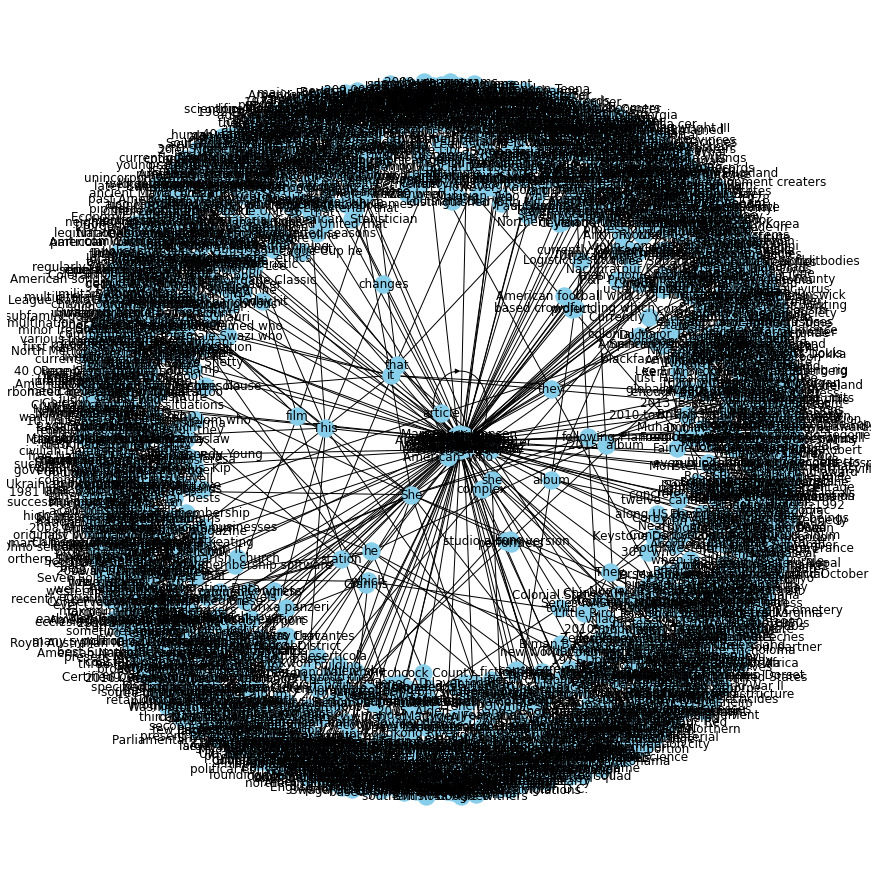

In [18]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation found in”:

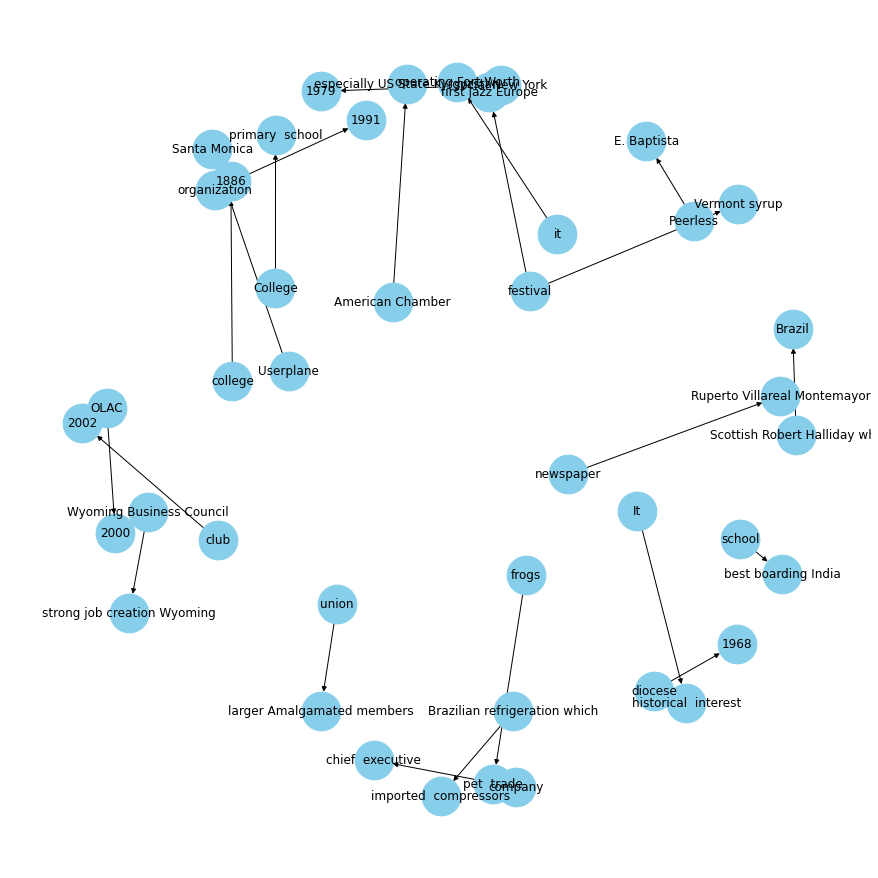

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="found in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Now I would like to visualize the graph for the “written by” relation:

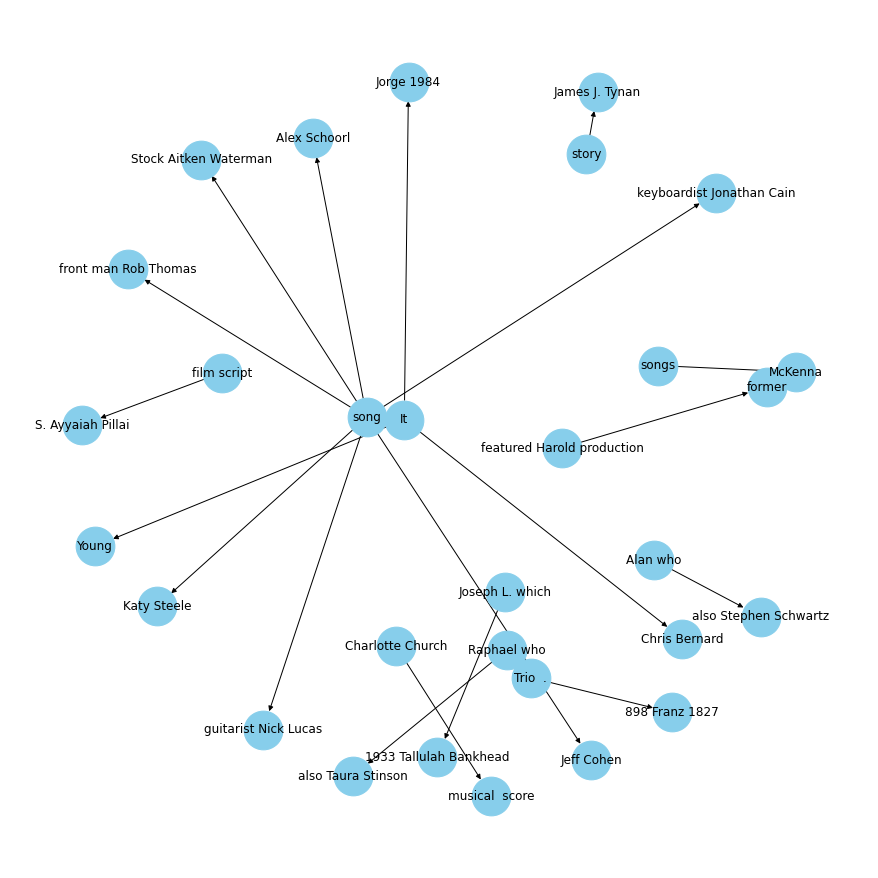

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="write by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

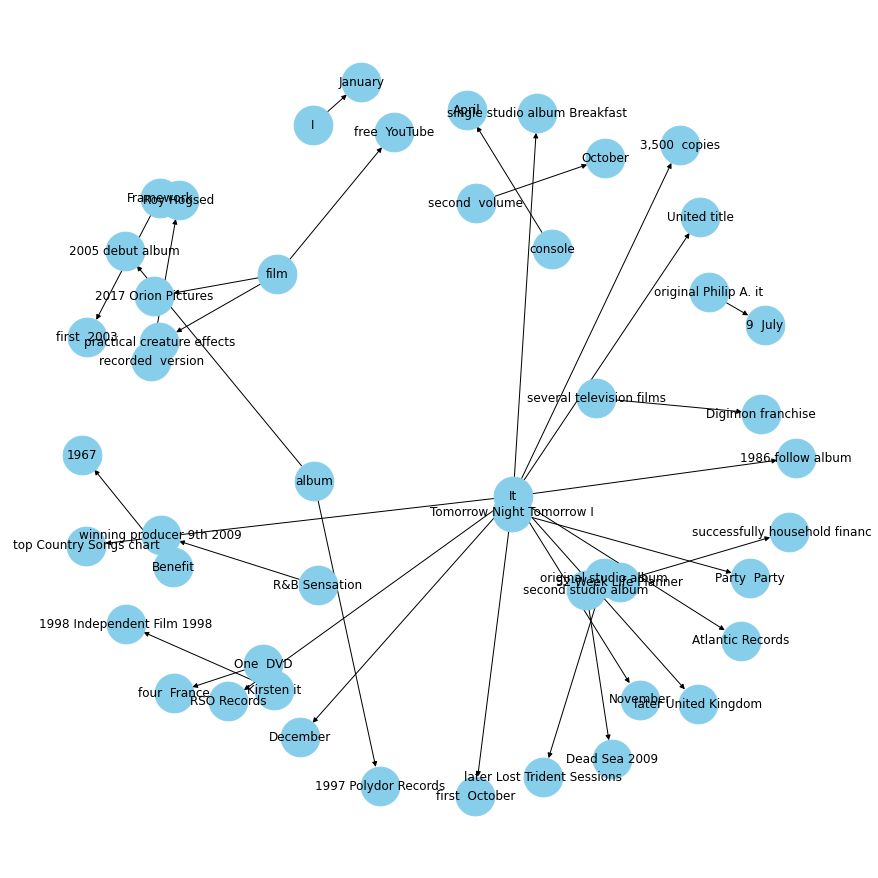

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="release in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()